## SUMMARY

The aim is to demonstrate how to extend the base class Genome to have different behaviour for recombination. Below two examples are considered:

1. Having more intense recombination in telomeres
2. Using a bionomial distribution to get the number of cross-overs instead of the default poisson (the results houdl be similar)

In [2]:
## for local developement
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [32]:
import quickgsim as gsim

## 0. Setting the instruction and inspection functionality

In [14]:
## Create two chromosomes, use the same instructions for all scenarios
instructions = {1:[20,1_000_000,2],2:[30,2_000_000,3]}

In [37]:
def do_recombs(g,chrom_name=1,iters=5000):
    results = np.zeros(len(g.chroms[chrom_name].xover_p))
    for i in range(iters):
        for rec in g.place_recomb(g.chroms[chrom_name],g.recomb_events(chrom_name,mod_len_chrom=0.2)):
            results[rec-1] += 1
    return results
    

def viz_recomb(g,chrom_name=1,iters=5000):
    print("> The probabilties for cross-over:")
    print(g.chroms[chrom_name].xover_p)
    results = do_recombs(g,chrom_name,iters)
    print(">Crossovers:")
    print(results)
    plt.bar(range(len(g.chroms[chrom_name].xover_p)),results)


## 1. Compare the base Genome with a Custom one

By using equidistant_genome() with the instructions, all markers are placed in equal mapping distances across chromosomes. This implies that the probability for a cross-over is the same between all markers in the genome (see the output of `genome.chroms[1].xover_p`). 

Alternatively, a Cusom Genome is defined by inheriting from the baseclass. The difference is that the new class modifies *self.chroms[c].xover_p* for all chromosomes *c* in a user-defined manner. In the example for this notebook, crossovers at the telomeres (defined as the first 30% of chromosome or the last 20%) are 4 times more likely than in regions between 30% to 80% of the chromosome. This is shown in the two histograms at the end of the section.

**NOTE**: The adjustment of the modified recombination profile is done explicitly AFTER adding all the markers by calling  `CustomGenome.adjust_recomb_profile()`


In [7]:
## Standard Genome using 
genome = gsim.equidistant_genome(instructions,rs=gsim.randomise(seed=42))

will now add 20 variants in chromosome 1 [len in bp:1000000/morgans:2.1] equally spaced every 52631 bp, ie every 11.05 centiMorgans
 chrom 1 has 20 variants
will now add 30 variants in chromosome 2 [len in bp:2000000/morgans:3] equally spaced every 68965 bp, ie every 10.34 centiMorgans
 chrom 2 has 30 variants


In [8]:
## print all the variants in chromosome 1
genome.chroms[1].variants

[Variant(chrom=1, pos=0.0, cm_pos=0.0, add_effects={}),
 Variant(chrom=1, pos=52631.57894736842, cm_pos=11.05263157894737, add_effects={}),
 Variant(chrom=1, pos=105263.15789473684, cm_pos=22.10526315789474, add_effects={}),
 Variant(chrom=1, pos=157894.73684210525, cm_pos=33.15789473684211, add_effects={}),
 Variant(chrom=1, pos=210526.31578947368, cm_pos=44.21052631578948, add_effects={}),
 Variant(chrom=1, pos=263157.8947368421, cm_pos=55.26315789473685, add_effects={}),
 Variant(chrom=1, pos=315789.4736842105, cm_pos=66.31578947368422, add_effects={}),
 Variant(chrom=1, pos=368421.05263157893, cm_pos=77.36842105263159, add_effects={}),
 Variant(chrom=1, pos=421052.63157894736, cm_pos=88.42105263157896, add_effects={}),
 Variant(chrom=1, pos=473684.2105263158, cm_pos=99.47368421052633, add_effects={}),
 Variant(chrom=1, pos=526315.7894736842, cm_pos=110.5263157894737, add_effects={}),
 Variant(chrom=1, pos=578947.3684210526, cm_pos=121.57894736842105, add_effects={}),
 Variant(chrom

In [9]:
## show that the probabilties for crossover are the same between all markers (after all, it is an equidistant genome)
genome.chroms[1].xover_p

array([0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556])

In [13]:
# A simple demonstration of getting the cross-over positions
genome.place_recomb(genome.chroms[1],genome.recomb_events(1))

array([ 1,  3,  4,  9, 13])

In [62]:
## This is an example of Genome with different recombination rate in telomeres vs centromeres
class CustomGenome(gsim.Genome):
    
    def adjust_recomb_profile(self,skip_first_last=True):
        """Favour recombination at the beginning or end of the chromosome"""
        start,end = None,None
        if skip_first_last:
            start,end = 1,-1
        
        if len(self.chroms) > 0:
            for c in self.chroms:
                l = self.chroms[c].length
                for idx,v in enumerate(self.chroms[c].variants[start:end]):
                    if 0.3 <v.pos/l < 0.8:
                        self.chroms[c].xover_p[idx] *= 0.5
                    else:
                        self.chroms[c].xover_p[idx] *= 2
                ## re-scale the probabilities in order to sum up to 1 in order to be used as weights in genome.place_recomb()
                self.chroms[c].xover_p /= self.chroms[c].xover_p.sum()
        print("Probabilities for xovers were updated")


In [102]:
## Note I first to have initialise the custom genome and then explicitly pass it to equidistant_genome(), otherwise the function by default it will return the base class
lala = CustomGenome()
g1 = gsim.equidistant_genome(instructions,lala,rs=None)

will now add 20 variants in chromosome 1 [len in bp:1000000/morgans:2] equally spaced every 52631.57894736842 bp, ie 0.10526315789473684 map units
 chrom 1 has 20 variants
will now add 30 variants in chromosome 2 [len in bp:2000000/morgans:3] equally spaced every 68965.5172413793 bp, ie 0.10344827586206896 map units
 chrom 2 has 30 variants


> The probabilties for cross-over:
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
>Crossovers:
[229. 218. 243. 212. 212. 229. 240. 239. 227. 235. 244. 233. 250. 261.
 222. 228. 253. 229.]


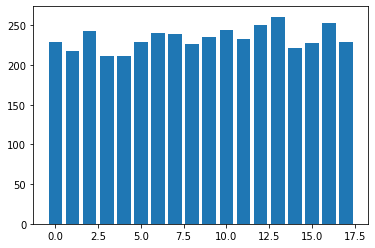

In [103]:
## before adjustment
viz_recomb(g1,chrom_name=1,iters=2000)

Probabilities for xovers were updated
> The probabilties for cross-over:
[0.0952381  0.0952381  0.0952381  0.0952381  0.0952381  0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.0952381  0.0952381  0.0952381 ]
>Crossovers:
[401. 414. 379. 377. 383. 103. 112. 107. 126. 100. 104. 107. 104. 110.
 105. 415. 370. 414.]


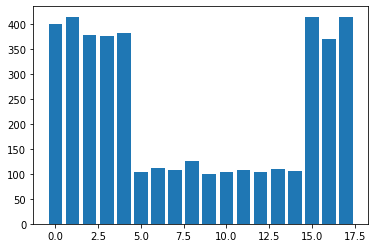

In [104]:
g1.adjust_recomb_profile()
viz_recomb(g1,chrom_name=1,iters=2000)

## 2. Compare using a Bionomial vs Poisson distribution to determine number of cross-overs

In this example, the base class Genome is extended by modifying recomb_events(). The idea is to use the Binomial distribution to draw the number of cross-overs (as in function [sample_genome](https://github.com/reworkhow/XSim.jl/blob/master/src/core/genome.jl) from XSim.jl) as opposed to the alternative to draw from a Poisson distribution (see for an alternative implementaion in package SeqBreed in function [mpeiosis](https://github.com/miguelperezenciso/SeqBreed/blob/master/src/genome.py)). In essence both approach should yield the similar results (for more background ,check this [slides](https://mathweb.ucsd.edu/~gptesler/283/slides/186_poisson_f19-handout.pdf)).

In [115]:
import math

class CustomGenome2(gsim.Genome):
    
    def recomb_events(self,chrom_name,obligatory=1,max_events_asPropChromLen=None):
        """Determines the number of cross-overs in a chromosome drawing from a poisson distribution
           Allows to specify the maximun number of events as a proportion of the chromosome length
        """
        if chrom_name in self.chroms:
            n_Binomial = math.ceil(self.chroms[chrom_name].morgans + 1)    #add 1 is optional, makes the chromosome "larger"
            p_Binomial = self.chroms[chrom_name].morgans/n_Binomial        #the expectation for number of crossovers
            r = self.rs.binomial(n_Binomial, p_Binomial)
            if max_events_asPropChromLen:
                max_recomb = self.chroms[chrom_name].morgans * max_events_asPropChromLen
                if r > max_recomb:
                    r = max_recomb
            return r if r >= 1 else obligatory
        return None

will now add 20 variants in chromosome 1 [len in bp:1000000/morgans:2] equally spaced every 52631.57894736842 bp, ie 0.10526315789473684 map units
 chrom 1 has 20 variants
will now add 30 variants in chromosome 2 [len in bp:2000000/morgans:3] equally spaced every 68965.5172413793 bp, ie 0.10344827586206896 map units
 chrom 2 has 30 variants
> The probabilties for cross-over:
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
>Crossovers:
[248. 218. 205. 209. 240. 240. 232. 224. 229. 218. 230. 229. 196. 260.
 225. 227. 215. 218.]


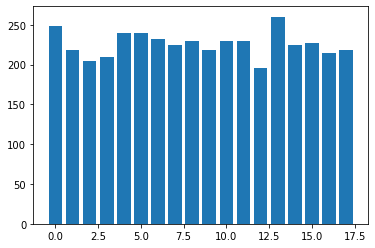

In [116]:
## In this occassion, the new Genome object has already modified behaviour, so need to adjust
lala2 = CustomGenome2()
g2 = gsim.equidistant_genome(instructions,lala2,rs=None)
viz_recomb(g2,chrom_name=1,iters=2000)

In [97]:
#Compare times between Bionomial and Poisson
%timeit do_recombs(g2,chrom_name=1,iters=2000)      #using the Bionomial, ie object g2

162 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
%timeit do_recombs(genome,chrom_name=1,iters=2000)  #using the Poisson, ie object genome

157 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit do_recombs(genome,chrom_name=1,iters=2000)

155 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
## with mod_len
g12 = gsim.equidistant_genome(instructions,rs=gsim.randomise(seed=42))

will now add 20 variants in chromosome 1 [len in bp:1000000/morgans:2] equally spaced every 52631 bp, ie every 10.53 centiMorgans
 chrom 1 has 20 variants
will now add 30 variants in chromosome 2 [len in bp:2000000/morgans:3] equally spaced every 68965 bp, ie every 10.34 centiMorgans
 chrom 2 has 30 variants


In [40]:
%timeit do_recombs(g12,chrom_name=1,iters=2000)

157 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
### This is developmental code. The idea was to generate a custom Distribution to draw xovers positions. This however adds complexity, while using the weights in the numpy.random.choice is much more simple

In [145]:
from scipy.stats import beta

In [168]:
samples = [beta.cdf(x,0.5,0.5) for x in np.arange(0.01,1,0.01)]

In [166]:
import seaborn as sns

/Users/andreas/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

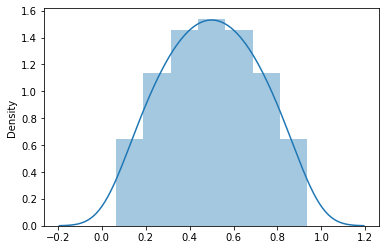

In [169]:
sns.distplot(samples)

In [179]:
def random_custDist(x0,x1,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=x0,high=x1)
        prop=custDist(x/x1)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
            #print(1,x,prop)
        nLoop+=1
    return samples

In [182]:
x0=0
x1=2
#chrom_size = 2
def custDist(x):
    if 0.2 < x < 0.8:
        return 0.3
    else:
        return 0.7

samples=random_custDist(x0,x1,custDist=custDist,size=1000)
print(samples[:10])

[0.36206854545774037, 1.8767107133010303, 1.709635905559415, 0.28566874280962185, 0.32514298053867674, 1.0059808486115218, 1.983586241152336, 1.4028123549688887, 0.3017890767748901, 1.9783923864838415]


/Users/andreas/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


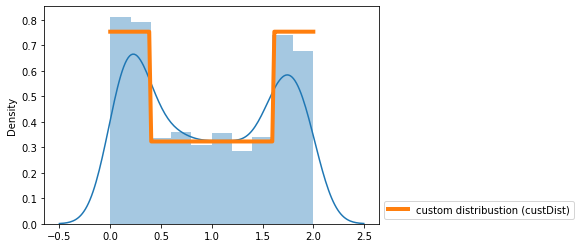

In [202]:
sns.distplot(samples,bins=10)

##dist
grid=np.linspace(x0,x1,100)
discCustDist=np.array([custDist(x/x1) for x in grid]) #distrete version
discCustDist*=1/(grid[1]-grid[0])/np.sum(discCustDist)
plt.plot(grid,discCustDist,label='custom distribustion (custDist)', color='C1', linewidth=4)
##decoration
plt.legend(loc=3,bbox_to_anchor=(1,0))
plt.show()

In [185]:
import scipy.stats as st

In [186]:
class my_pdf(st.rv_continuous):
    def _pdf(self,x):
        if 0.2 < x < 0.8:
            return 0.3
        else:
            return 0.7


In [187]:
my_cv = my_pdf(a=0, b=1, name='my_pdf')

/Users/andreas/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1801: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/andreas/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

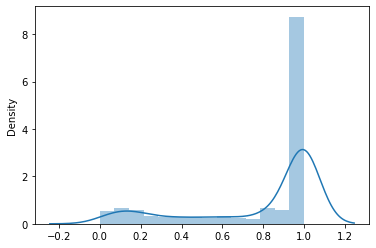

In [197]:
samples2 = [my_cv.rvs() for i in range(1000)]
sns.distplot(samples2)
